In [17]:
# Import libraries and setup matplotlib defaults
from matplotlib import pyplot as pl
import pandas as pd
import numpy as np
pl.style.use('bmh')
clist = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
         '#ffff33', '#a65628', '#f781bf', '#999999']
prop_cycle = pl.cycler(color=clist)

from matplotlib.colors import ListedColormap
cmap = ListedColormap([clist[0], clist[1]])

pl.rcParams.update({
    'axes.prop_cycle': prop_cycle,
    'lines.linewidth': 2,
    'font.size': 18,
    'figure.figsize': [10, 7],
    'figure.subplot.left': 0.125,
    'figure.subplot.right': 0.95,
    'figure.subplot.bottom': 0.15})

days_per_year = 365.25

In [18]:
%%capture
# set up path to include parent directory
import sys
sys.path.append('../')

# Import everything from the data_utils library
from data_utils import *

# Load the talk data
talk_data = get_only_talks(load_data())

In [19]:
apostle_bio_data = pd.read_csv('../data/apostles_bio_data.csv',
                               index_col=0, parse_dates=['Born', 'Died'])
apostle_calling_data = pd.read_csv('../data/apostles_calling_data.csv',
                                   index_col=0, parse_dates=['date_start', 'date_end'])

apostle_data = apostle_bio_data[['Name', 'Born', 'Died']].join(
    apostle_calling_data[apostle_calling_data['position']=='LDS Church Apostle'].drop(
        columns=['Name', 'position']))

## Data cleanup
# 1. deal with the Orsons, so their dates don't mess up the seniority calculations
special_cases = ['Orson Pratt', 'Orson Hyde']
for name in special_cases:
    ref_data = apostle_calling_data[(apostle_calling_data['Name']==name) &
                                    (apostle_calling_data['position']=='Quorum of the Twelve Apostles')
                                   ].sort_values('date_end').iloc[-1].transpose()
    apostle_data.loc[apostle_data['Name']==name, 'date_start'] = ref_data['date_start']
    apostle_data.loc[apostle_data['Name']==name, 'date_end'] = ref_data['date_end']    

# 2. deal with the non-quorum apostles
data = (('John Willard Young', 'date_start', 'Counselor in the First Presidency'),
        ('John Willard Young', 'date_end', 'First Counselor in the First Presidency'),
        ('Daniel H. Wells', 'date_end', 'Second Counselor in the First Presidency'),
        ('Alvin R. Dyer', 'date_end', 'Counselor in the First Presidency'))
for name, dt_type, calling in data:
    apostle_data.loc[apostle_data['Name']==name, dt_type] = \
    apostle_calling_data.loc[(apostle_calling_data['Name']==name) &
                         (apostle_calling_data['position']==calling), dt_type]

# above code is mangling types for some reason
apostle_data = apostle_data.astype({'date_start': np.datetime64, 'date_end': np.datetime64})


apostle_data['short name'] = apostle_data['Name'].map(shorten_name)
apostle_sn_dict = apostle_data[['Name', 'short name']].set_index('Name').to_dict()['short name']

president_list = apostle_calling_data[apostle_calling_data['position']=='President of the Church']['Name'].to_list()

apostle_data['office']=0
apostle_data.loc[apostle_data['Name'].isin(president_list), 'office']=1

In [20]:
date_diff_years = lambda x, y: (apostle_data[x]-apostle_data[y]).dt.days/days_per_year
apostle_data['age_end'] = date_diff_years('date_end', 'Born')
apostle_data['age_at_call'] = date_diff_years('date_start', 'Born')
apostle_data['service_years'] = date_diff_years('date_end', 'date_start')
apostle_data['era_start'] = ((apostle_data['date_start'].dt.year//20)*20).apply(lambda y: f'{y:.0f}-\n{y+19:.0f}')
apostle_data['era_end'] = ((apostle_data['date_end'].dt.year//20)*20).apply(lambda y: f'{y:.0f}-\n{y+19:.0f}')

In short, yes.

The plot below shows the average age of all apostles (which includes all currently serving members of the Quorum of the Twelve Apostles and the First Presidency) from 1860 to the present, along with the age of the oldest and youngest apostle. The year 1860 is chosen as the starting point because it is after the current succession scheme had been established and membership in the quorum had stabilized. The original twelve apostles called in the 1830s were all quite young at the time (20s and 30s), and those who were still part of the quorum by 1860 had aged to their 50s and 60s. Up until about 1900, the average age of the apostles was between 50 and 60. Between 1900 and 1940, that average age drifted up to about 70. It remained relatively stable around 70 until the mid 1980s, when it began to drift upward again. The average age of the apostles on January 1, 2023 was 78.7 years, the second highest it has ever been (it was briefly over 79 years in 2015 before the deaths of 3 senior apostles in short succession).

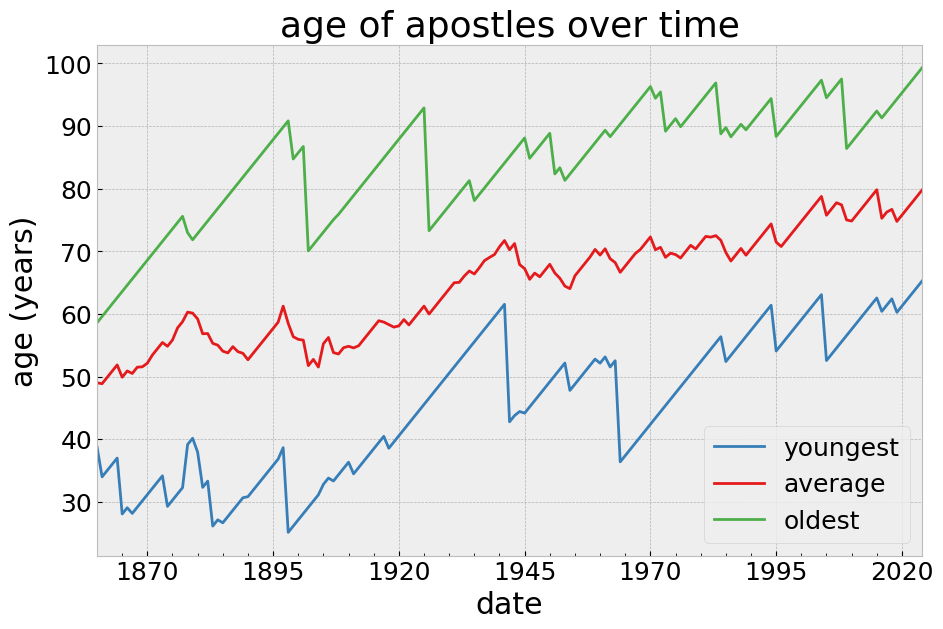

In [21]:
# Compute average age of apostles on January 1 each year
years = pd.Series([str(yr)+'-01-01' for yr in np.arange(1860, 2025)]).astype(np.datetime64)

ages = []
for year in years:
    all_ages = year - apostle_data.loc[(apostle_data.date_start<year) &
                                       ((apostle_data.date_end>year) |
                                        apostle_data.date_end.isna()), 'Born']
    ages.append([all_ages.min(), all_ages.mean(), all_ages.max()])

columns = ['youngest', 'average', 'oldest']
age_data = pd.DataFrame(ages, index=years, columns=columns)
age_data.index.name='date'
for col in columns:
    age_data[col] = age_data[col].dt.days/days_per_year

_ = age_data.plot(
    ylabel='age (years)',
    title='age of apostles over time')

The chart below shows the average age of death of apostles at death, grouped into 20-year periods. The number at the bottom of each bar indicates the number of apostles who died during that period.

Superimposed on the bar chart is U.S. life expectancy data since the 1940s. Two values are shown (computed as means over the corresponding 20 year periods), life expectancy for males at birth, and life expectancy for males at age 65. In the 1940s a majority, but not all, of the apostles would have been over 65, while at present all but one are. Remarkably, it seems that while the average age at death of apostles in the 1940s and 50s was pretty close to the U.S. life expectancy for a 65 year old, the life expectancy of apostles has increased faster than the life expectancy of the rest of the male over-65 population, with the average age of death for the apostles who died 2000-2019 being almost 90 years.

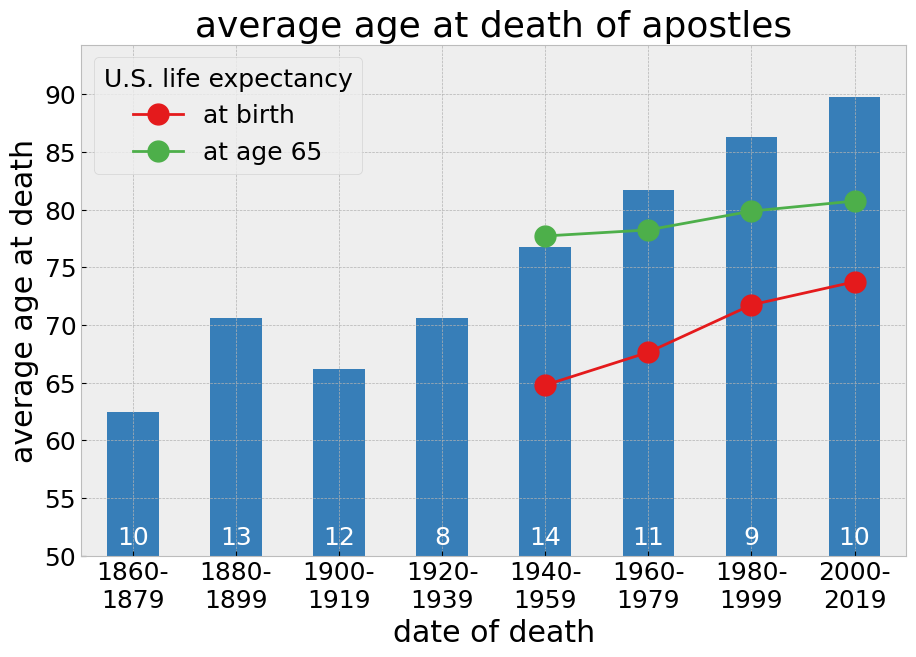

In [22]:
life_expectancy_data = apostle_data[['age_end', 'Died']].copy()
life_expectancy_data['era'] = \
    ((life_expectancy_data['Died'].dt.year//20)*20).apply(lambda y: f'{y:.0f}-\n{y+19:.0f}')
life_expectancy = life_expectancy_data.groupby('era')['age_end'].mean().to_frame()
life_expectancy['deaths'] = life_expectancy_data.groupby('era').size()
include = (life_expectancy.index>'1850') & ~life_expectancy['age_end'].isna()
le_filt = life_expectancy[include].copy()

le_ref_data = pd.read_csv('../data/life_expectancy.csv', header=1)
le_ref_data['era_end'] = ((le_ref_data['year']//20)*20).apply(lambda y: f'{y:.0f}-\n{y+19:.0f}')
le_era_ref = le_ref_data.groupby('era_end').mean()
le_filt['at birth'] = le_era_ref['Male']
le_filt['at age 65'] = le_era_ref['Male.1'] + 65

ax = le_filt['age_end'].plot.bar(
    rot=0,
    ylim=[50, None],
    ylabel='average age at death',
    xlabel='2 decade period',
    title='average age at death of apostles')

for idx, val in enumerate(le_filt['deaths']):
    ax.annotate(str(val), (idx, 51), ha='center', color='white')

le_filt[['at birth', 'at age 65']].plot(ax=ax, color=clist[1:], marker='.', ms=30, xlabel='date of death')
pl.gca().get_legend().set_title('U.S. life expectancy')

While the age at death of apostles has gone up over time, the age at which they are called has also increased correspondingly. The chart below shows the average years of service as an apostle (or member of the First Presidency) for all of the apostles who died during the eras shown in the last chart. There have been some fluctuations in this number, but overall it has been much more stable than the age at death, increasing by about 5 years since the 1940s.

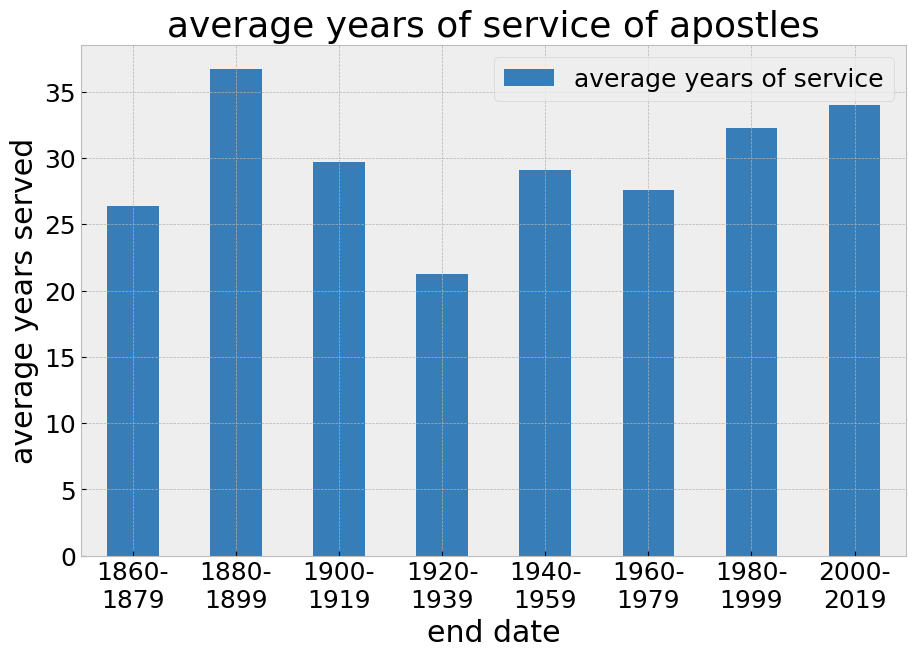

In [23]:
sy_data = apostle_data.groupby('era_end')['service_years'].mean().to_frame('average years of service')
_ = sy_data[1:-1].plot.bar(rot=0, title='average years of service of apostles',
                      xlabel='end date',
                      ylabel='average years served')

The chart below contains a scatter plot of all apostles and their date of call and age when they were called. Apostles who became president of the church are marked in red to make them identifiable. In this case, current church president Russell Nelson stands out: at nearly 60 years old when called to be an apostle, he was nearly a decade older than anyone else who later became president of the church.

There was a big shift between about 1900 and 1950 from most apostles being called in their 30s and 40s, to the modern era where most are over 50. Nobody under 50 has been called to be an apostle since 1970. The age range for newly called apostles has further narrowed more recently. In the last 20 years virtually all new apostles have been between about 55 and 65.

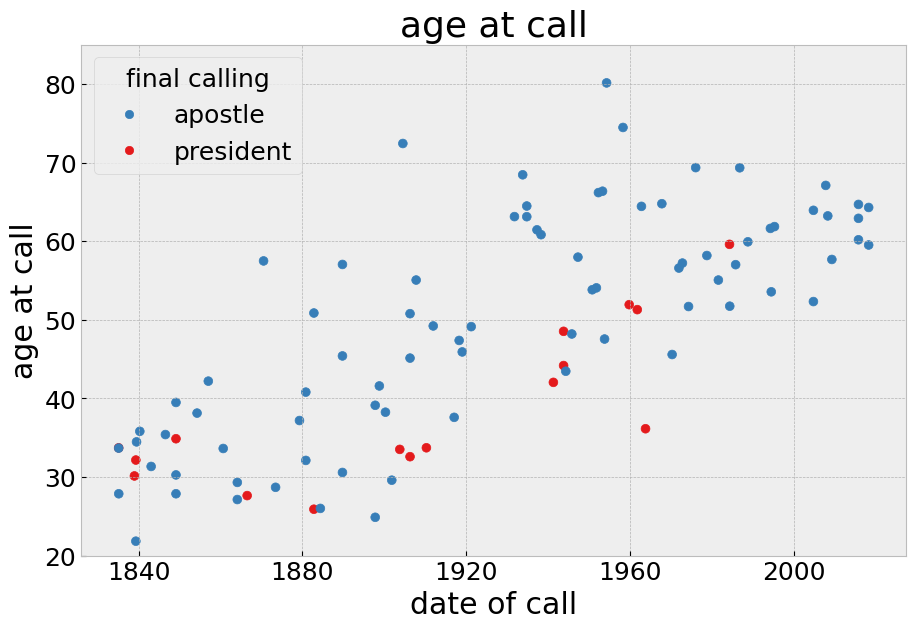

In [24]:
sc = pl.scatter(apostle_data['date_start'],
                apostle_data['age_at_call'],
                c=apostle_data['office'], cmap=cmap, s=40)
pl.ylim([20, 85])
pl.xlabel('date of call')
pl.ylabel('age at call')
pl.title('age at call')

# the legend_elements() command below is causing warnings for some reason
import warnings
warnings.filterwarnings('ignore')

_ = pl.legend(sc.legend_elements()[0], ['apostle', 'president'], title='final calling')

## How long does it take to become president of the church?
The seniority system of succession that has been in place since Brigham Young means that to become president of the church, one must be called to be an apostle, and then survive 14 of one's fellow apostles.

The plot below shows how many years each president of the church since Brigham Young served as an apostle prior to becoming president of the church. Brigham Young is an outlier here because the church was new and the succession scheme not yet established. Since Brigham Young, most presidents of the church served for 30 to 45 years.

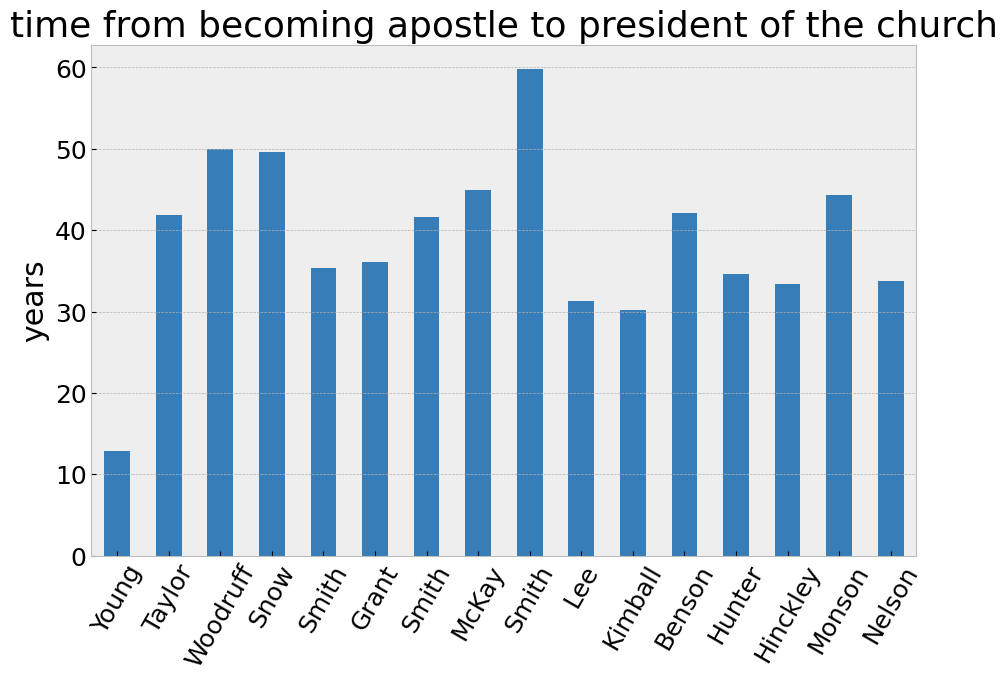

In [25]:
pres_dates = apostle_calling_data[apostle_calling_data['position']=='President of the Church'][['Name', 'date_start']]
pres_dates = pres_dates.rename(columns={'date_start': 'start_p'}).merge(apostle_data[['Name', 'date_start']])
pres_dates['time_to_pres'] = (pres_dates['start_p']-pres_dates['date_start']).dt.days/days_per_year
pres_dates['short name'] = pres_dates['Name'].str.split(' ').str[-1]
pres_dates = pres_dates[~pres_dates['time_to_pres'].isna()]
pres_dates.set_index('short name')['time_to_pres'].plot.bar(
    xlabel='', ylabel='years', rot=60, title='time from becoming apostle to president of the church')
pl.gca().grid(axis='x')

A related question to how long it takes to move from seniority rank 15 to seniority rank 1 is where apostles typically end up in seniority rank when they die. The chart below shows the distribution of seniority ranks at death of all deceased apostles. Seniority rank 1 represents presidents of the church. Joseph Smith is excluded from this analysis because the seniority system did not yet exist in his lifetime, so while there have been 17 presidents of the church, only 16 reached rank 1 since Brigham Young. The median final rank of apostles is 5.

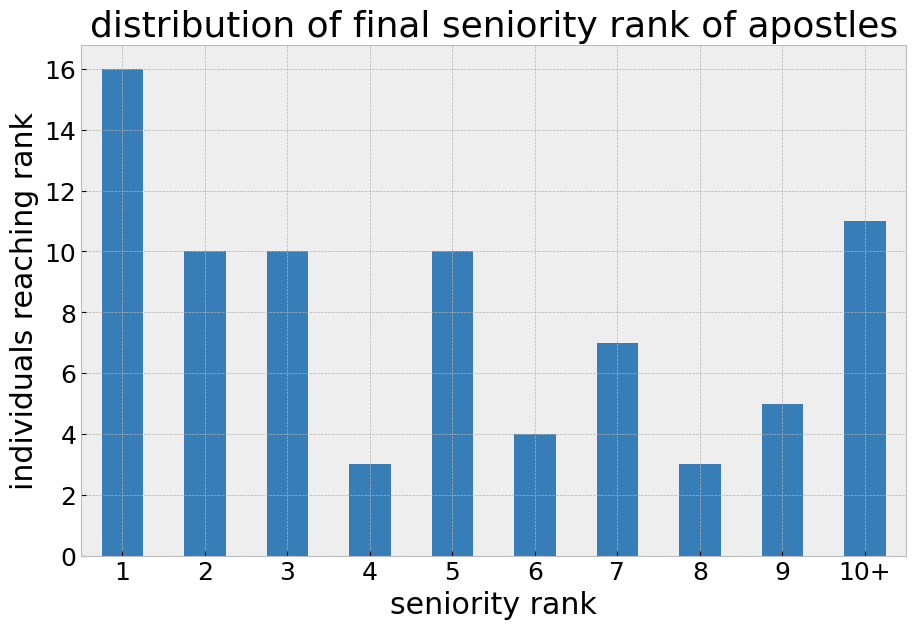

In [26]:
# Compute seniority rank of apostles at end

# version 1 -- only deceased apostles
end_dates = apostle_data[~apostle_data['date_end'].isna()][['Name', 'date_end']]

# version 2 -- include currently living
#end_dates = apostle_data[(apostle_data['edate']>'1860-01-01') |
#                         (apostle_data['sdate']>'1900-01-01')][['name', 'edate']]
#end_dates.loc[end_dates['edate'].isna(), 'edate'] = '2023-01-01'

rdict = {}
for name, dt in (end_dates.set_index('Name')['date_end']-np.timedelta64(1, 'D')).to_dict().items():
    adf = apostle_data[(apostle_data['date_start']<dt) &
                           ((apostle_data['date_end']>dt) | (apostle_data['date_end'].isna()))]
    rank_name = adf.reset_index().sort_values(['date_start', 'index']).reset_index()['Name']
    rdict.update({name: rank_name[rank_name == name].index[0] + 1})

final_rank_data = apostle_data.merge(
    pd.Series(rdict).to_frame('rank'), left_on='Name', right_index=True)

frd = final_rank_data[final_rank_data['date_end']>'1860-01-01']
hist_data = frd.groupby('rank').size()#/len(final_rank_data)
threshold = 10
hd_new = hist_data[hist_data.index<threshold].copy()
hd_new.loc[f'{threshold}+'] = hist_data[hist_data.index>=10].sum()

hd_new.plot.bar(rot=0,
                ylabel='individuals reaching rank',
                xlabel='seniority rank',
                title='distribution of final seniority rank of apostles')

med_rank = frd['rank'].median()

## What callings did apostles have when called to be an apostle?
Many recently called apostles had already been serving as general authorities before being called as an apostle. The chart below shows the fraction of apostles called in each 20 year period since 1840 who had previously served as general authorities. Four of the apostles called since 1980 have served in another high-profile leadership position in the church that is not one of the general authorities: president of a church-owned college or university (Oaks, Eyring, Holland, and Bednar). These have been marked using a separate color in the chart. Two of them (Holland and Eyring) served both as college or university presdients and general authorities.

If we include both forms of prior church leadership experience, a trend is clear: it was quite rare for apostles called before the mid 20th century to have already been serving as a general authority, but over 90% of those called since 1960 served as either a general authority or president of a church college. Since 1985 that number is 100%. Current church president Russell Nelson is the last apostle not to have served in either capacity.

One possible cause of this is likely the expansion in the ranks of general authorities. In the 1940s the office of "Assistant to the Quorum of the Twelve Apostles" was created, and in the 1970s the Quorums of the Seventy were significantly expanded and most of those previously serving as Assistant to the Twelve were called to be Seventies. This expanded number of general authorities created a now sizable pool of people who had already had experience in church administration and who were already well known to the church president extending the calling. Serving in the quorums of the Seventy and Presiding Bishopric has evolved into an opportunity for vetting future apostles.

In [27]:
# Remove overlaps from prior calling data for subsequent calculations.
# Also drop "LDS Chruch Apostle", which appears to refers to ordination
# status rather than current calling and interferes with some calculations.
acd_no = apostle_calling_data.reset_index().sort_values(['index', 'date_start']).set_index('index')
acd_no = acd_no[acd_no['position']!='LDS Church Apostle']
next = acd_no[['Name', 'date_start']].shift(-1)
replace_idx = (acd_no['Name']==next['Name']) & (acd_no['date_end']>next['date_start'])
acd_no.loc[replace_idx, 'date_end'] = next.loc[replace_idx, 'date_start']

# merge prior callings with main data
calling_merged = apostle_data[['date_start', 'date_end']].join(acd_no, lsuffix='_a')
prior_callings = calling_merged[calling_merged['date_end']<=calling_merged['date_start_a']]
prior_callings = prior_callings[prior_callings['Name']!='J. Reuben Clark']

date_diff_years2 = lambda data, x, y: (data[x]-data[y]).dt.days/days_per_year
prior_callings['years'] = date_diff_years2(prior_callings, 'date_end', 'date_start')
uni_idx = prior_callings['position'].str.startswith('[non-GA]')
prior_callings['uni_years'] = 0
prior_callings.loc[uni_idx, 'uni_years'] = prior_callings.loc[uni_idx, 'years']
prior_callings['years'] = prior_callings['years'] - prior_callings['uni_years']
pc_totals = prior_callings.groupby('Name')[['years', 'uni_years']].sum().reset_index()

ad_with_prior = apostle_data.merge(pc_totals, how='left', on='Name').fillna({'years': 0, 'uni_years': 0})
ad_with_prior['general authority'] = (ad_with_prior['years']>0).astype(int)
ad_with_prior['university president'] = (ad_with_prior['uni_years']>0).astype(int)
ad_with_prior['both'] = ad_with_prior[['general authority', 'university president']].min(1)
ad_with_prior['general authority'] -= ad_with_prior['both']
ad_with_prior['university president'] -= ad_with_prior['both']

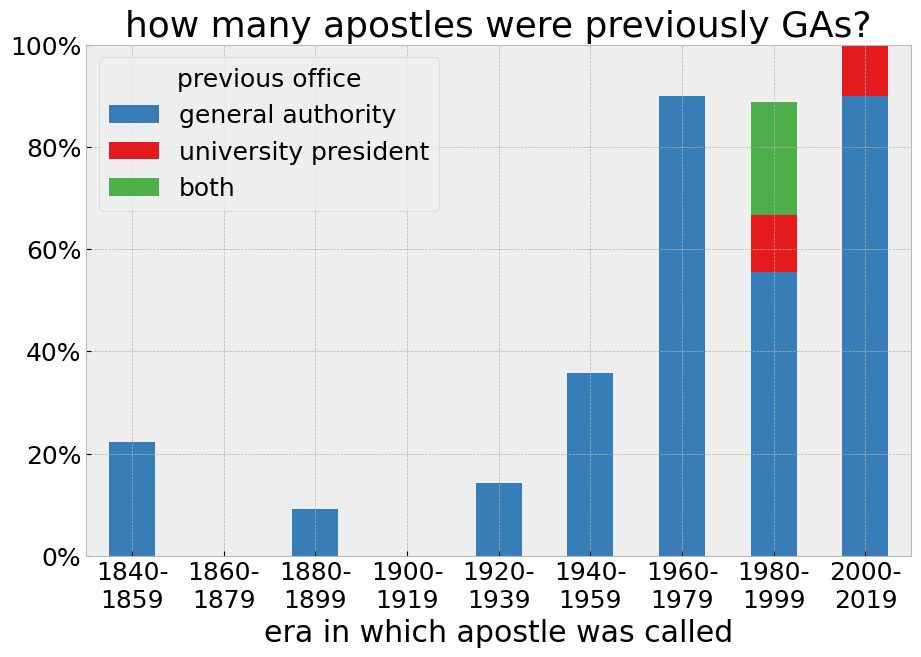

In [28]:
prev_served_totals = ad_with_prior[['era_start', 'general authority',
                                    'university president', 'both']].groupby('era_start').mean()
prev_served_totals.iloc[1:-1].plot.bar(rot=0, ylim=[0, 1], xlabel='era in which apostle was called',
                                      title='how many apostles were previously GAs?',
                                      stacked=True)
pl.gca().set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1], ['0%', '20%', '40%', '60%', '80%', '100%'])
_ = pl.legend(title='previous office')

In addition to the fraction of those previously serving in church administration going to effectively 100%, the number of years served in those roles prior to being called as an apostle has also increased over time. The chart below shows the number of prior years of service (including as a church college president) for apostles called in each of those same 20-year time period. That average number of years has steadily increased, even since 1960, with the average number of years of prior service for the 10 apostles called since 2000 being just over 10.

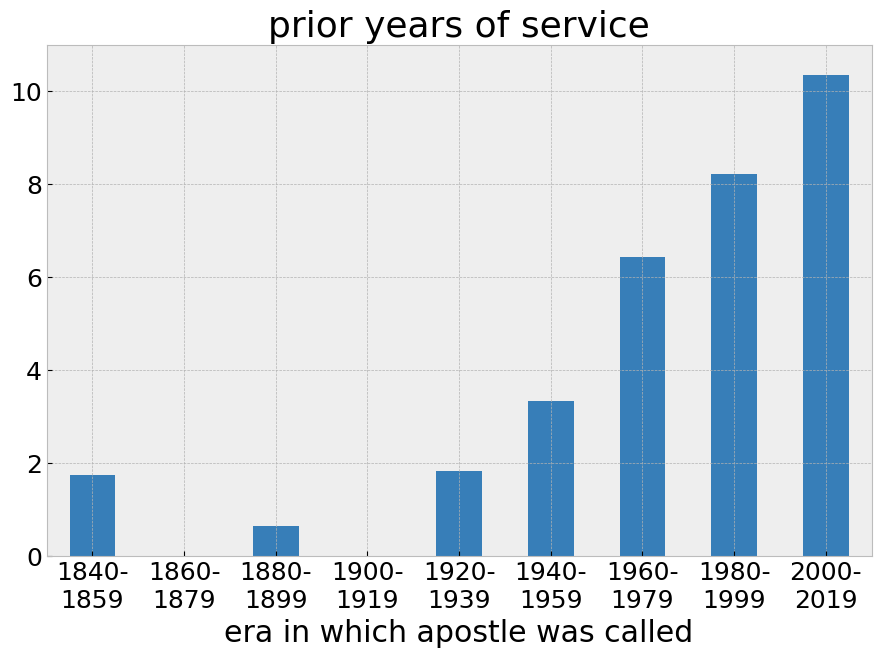

In [29]:
_ = ad_with_prior.groupby('era_start')['years'].mean().iloc[1:-1].plot.bar(
    rot=0, ylim=[0,11],
    xlabel='era in which apostle was called',
    title='prior years of service')

Since 1985, 100% of newly called apostles (16 total) had previously served in church administration. The chart below shows a breakdown of the role they had at the time they were called. A significant majority of them had been in the Presidency of the Seventy. This is not particularly surprising since in the current era, being in the Presidency of the Seventy is closest in its responsibilities to that of an apostle of any of the general authority callings. One of the most visible responsibilities is speaking in general conference. This [analysis](https://qhspencer.github.io/lds-data-analysis/general-stats/) of general conference speakers showed that on average a typical Seventy in recent decades may go 5 or more years between general conference speaking assignments, while members of the Presidency of the Seventy speak on average every 1.5 years. Members of that group represent the general authorities who are the most experienced and trusted by the higher leadership.

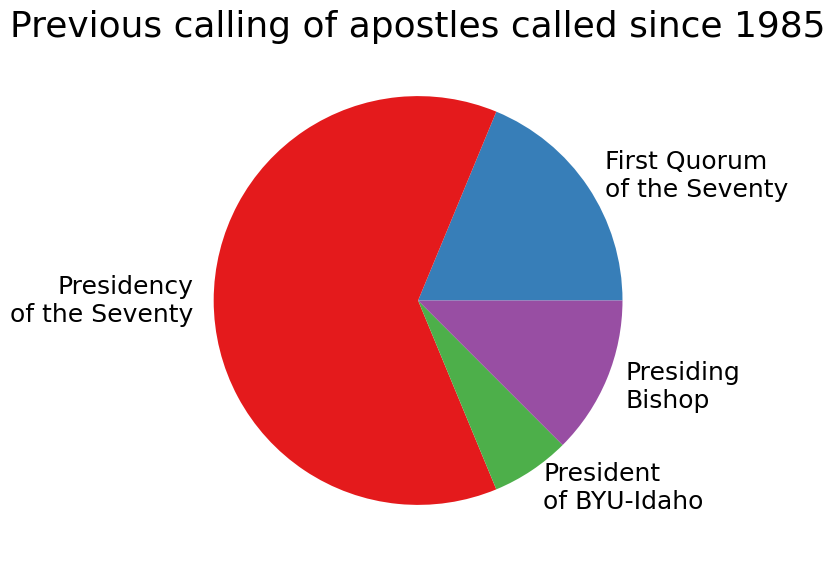

In [30]:
recently_called = calling_merged[calling_merged['date_start_a']>'1985-01-01']
recent_last_calling = recently_called[recently_called['date_end']<=recently_called['date_start_a']].groupby('Name').last()
recent_last_calling['position'] = recent_last_calling['position'].str.replace(r'\[non-GA\] ', '', regex=True)
totals = recent_last_calling.groupby('position').size()
totals.index = totals.index.str.replace(r' (?=(of|Bi))', '\n', regex=True)
_ = totals.plot.pie(title='Previous calling of apostles called since 1985', ylabel='')

In [31]:
%%capture
len(recent_last_calling)
## number of apostles called since 1985: 16

## How to become an apostle
Based on this analysis, nearly all apostles in recent years meet the following criteria:
 * in his late 50s or early 60s
 * a decade of prior service as a general authority
 * currently serving in the Presidency of the Seventy or as Presiding Bishop.

To become an apostle, one must therefore become a general authority in one's early 50s or younger, and within a few years be called into higher leadership callings among the general authorities. And one must not be too old when a vacancy is open in the Quorum of the Twelve. Becoming president of the church requires living at least another 30 years beyond that.

In [32]:
# Setup show/hide source code box
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="show/hide source code"></form>''')